# Excerpt

1.Applied Naive Bayes using Bernoulli NB and Multinomial NB on Different Featurization of Data viz. BOW(uni-gram,bi-gram), 
tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec 

2.Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted 
Confusion matrix using seaborne

3.Printed Top 25 Important Features for both Negative and Positive Reviews

# Data includes:

Reviews from Oct 1999 - Oct 2012
568,454 reviews

256,059 users

74,258 products

260 users with > 50 reviews

# Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv('Reviews.csv')
df.head()
df.dropna(inplace=True)
df[df['Score'] != 3]
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=df.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393919, 11)

In [6]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shashank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'we', 'yourselves', 'it', 'can', 'll', 'an', 'but', 't', 'about', 'again', 'he', 'then', 'so', 'm', 'aren', 'against', "doesn't", 'himself', "weren't", 'those', 'only', 'mightn', 'shan', 'y', 'does', 'myself', 'other', 'further', 'here', 'on', 'why', 'more', "it's", 'how', 'd', "should've", 'mustn', 'will', "you've", 'hasn', 'this', "needn't", 'were', 'any', "you're", 'own', 'she', 'them', 'doesn', 'that', 'wasn', 'isn', 'yours', 'hadn', 'than', 'ain', 'its', 'each', 'of', "haven't", 'by', 'be', 'itself', 'who', 'do', 'your', 'should', 'couldn', "shan't", 'between', 'was', 'what', "you'll", 'too', 'while', "mightn't", 'i', "that'll", 'few', 'no', 'ours', 'some', 'weren', 'my', 'and', "don't", 'or', 'out', 'same', 'below', 'been', 'hers', 'ma', 'if', 've', 'needn', 'before', 'themselves', 'haven', 'just', 'am', "couldn't", 's

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [10]:
df['Score'].size

568411

In [12]:
#sampling data points
new_final_counts=final[:25001]
print(new_final_counts.shape)

(25001, 12)


# BOW
A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.
OR 
Simply,Converting a collection of text documents to a matrix of token counts

In [27]:
#Breaking into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_final_counts['CleanedText'].values,new_final_counts['Score'].values ,test_size=0.30,shuffle=False)
#bow
count_vect=CountVectorizer()
final_counts=count_vect.fit_transform(X_train)

from sklearn import preprocessing
#Normalize Data
X_train_counts = preprocessing.normalize(final_counts)
print("Train Data Size: ",X_train.shape)
X_test=count_vect.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)


Train Data Size:  (17500,)
Test Data Size:  (7501, 17379)


In [28]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)

In [29]:
for train, cv in tscv.split(X_train_counts):

    print(X_train_counts[train].shape, X_train_counts[cv].shape)

(1600, 17379) (1590, 17379)
(3190, 17379) (1590, 17379)
(4780, 17379) (1590, 17379)
(6370, 17379) (1590, 17379)
(7960, 17379) (1590, 17379)
(9550, 17379) (1590, 17379)
(11140, 17379) (1590, 17379)
(12730, 17379) (1590, 17379)
(14320, 17379) (1590, 17379)
(15910, 17379) (1590, 17379)


# Searching the  efficient parameter tuning using GridSearchCV

In [30]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid =  {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
grid = GridSearchCV(bnb, param_grid, cv=10, scoring='accuracy', return_train_score=False)# instantiate the grid
grid.fit(X_train_counts,y_train)

print("Best HyperParameter: ",grid.best_params_)
print("Best Accuracy: %.2f%%"%(grid.best_score_*100))

Wall time: 0 ns
Best HyperParameter:  {'alpha': 1000}
Best Accuracy: 70.40%


In [31]:
# view the results as a pandas DataFrame
import pandas as pd
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.704000,0.000180,{'alpha': 1000}
1,0.704000,0.000180,{'alpha': 500}
2,0.704000,0.000180,{'alpha': 100}
3,0.703886,0.000291,{'alpha': 50}
4,0.699486,0.006806,{'alpha': 10}
5,0.691829,0.013024,{'alpha': 5}
6,0.671371,0.029208,{'alpha': 1}
7,0.670857,0.033347,{'alpha': 0.5}
8,0.664229,0.031262,{'alpha': 0.1}
9,0.662914,0.027553,{'alpha': 0.05}


In [32]:
 #examine the first result
print(grid.cv_results_['params'][0])
print(grid.cv_results_['mean_test_score'][0])

{'alpha': 1000}
0.704


In [33]:
# print the array of mean scores only
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.704      0.704      0.704      0.70388571 0.69948571 0.69182857
 0.67137143 0.67085714 0.66422857 0.66291429 0.66982857 0.6724
 0.6752     0.67594286 0.6756    ]


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


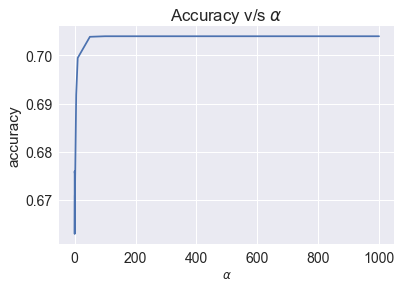

In [34]:
x=[]
y=[]
sns.set_style("darkgrid")
for a in grid.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])

plt.xlabel(r"$\alpha$",fontsize=12)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

# observation:-
It can be seen from the graph above that for  large value of alpha accuracy remains constant    

Accuracy on test set: 70.444%
Precision on test set: 0.704
Recall on test set: 0.704
F1-Score on test set: 0.704
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



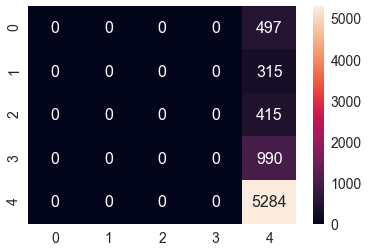

In [35]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
bnb = BernoulliNB(alpha=1000)
bnb.fit(X_train_counts,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='micro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='micro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4) #for label size                     
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Multinomial Naive Bayes
  This classifier is suitable for discrete data

In [36]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_counts,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 70.50%


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.9s finished


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


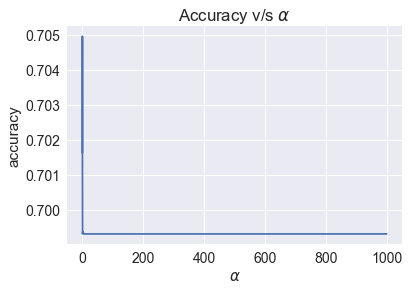

In [37]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])

plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

observation:
In the above graph for alpha=0 accuracy is maximum.As the value of alpha increases the accuracy decreases from maximum value
 and remains constant at certain value.
    

Accuracy on test set: 70.444%
Precision on test set: 0.704
Recall on test set: 0.704
F1-Score on test set: 0.704
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



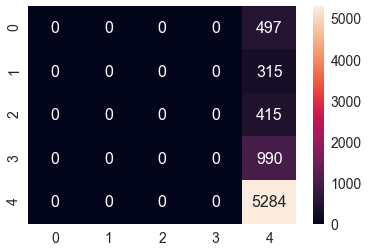

In [42]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
mnb = MultinomialNB(alpha=1000)
mnb.fit(X_train_counts,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='micro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='micro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(5),range(5))
sns.set(font_scale=1.4) #for label size                     
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [43]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,bnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-1.1346	aaaaah         				-0.8191	tast           
	-1.1346	aaah           				-0.8308	like           
	-1.1346	aagh           				-0.8532	product        
	-1.1346	aah            				-0.8996	one            
	-1.1346	aardvark       				-0.9244	tri            
	-1.1346	ab             				-0.9260	order          
	-1.1346	aback          				-0.9284	would          
	-1.1346	abandon        				-0.9649	good           
	-1.1346	abba           				-0.9649	get            
	-1.1346	abc            				-0.9666	buy            
	-1.1346	abdomen        				-0.9759	even           
	-1.1346	abhor          				-0.9853	dont           
	-1.1346	abid           				-0.9923	eat            
	-1.1346	abil           				-0.9949	flavor         
	-1.1346	abj            				-1.0089	amazon         
	-1.1346	abliti         				-1.0115	use            
	-1.1346	abnorm         				-1.0115	box      

# Tf-Idf

In [27]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train1, y_test = train_test_split(new_final_counts['CleanedText'].values,new_final_counts['Score'].values ,test_size=0.30,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train_tfidf=tfidf.fit_transform(X_train)



#Normalize Data
X_traintfidf_counts = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_traintfidf_counts.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 336894)
Test Data Size:  (7501, 336894)
Wall time: 5.12 s


In [53]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_traintfidf_counts,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 17 candidates, totalling 170 fits
Best HyperParameter:  {'alpha': 1000}
Best Accuracy: 69.93%


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   56.6s finished


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


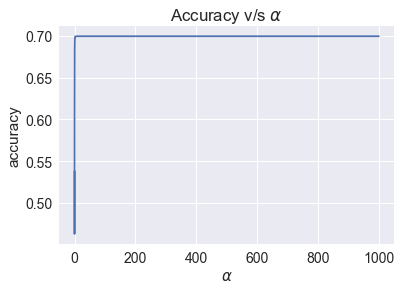

In [55]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])


plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

# observation:
for small values of alpha the accuracy is maximum while as value of alpha increases accuracy remains constant    

Accuracy on test set: 70.391%
Precision on test set: 0.704
Recall on test set: 0.704
F1-Score on test set: 0.704
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



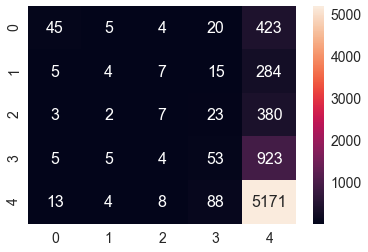

In [61]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
mnb = MultinomialNB(alpha=.0001)
mnb.fit(X_traintfidf_counts,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='micro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='micro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(5),range(5))
sns.set(font_scale=1.4) #for label size                     
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Multinomial Naive Bayes

In [63]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_traintfidf_counts,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.1}
Best Accuracy: 70.03%


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.6s finished


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


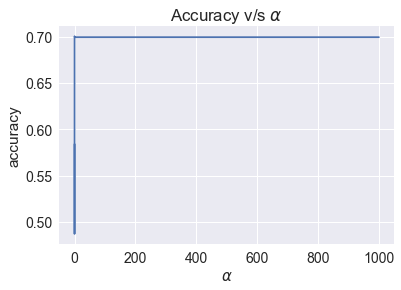

In [64]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])

plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

# observation
 Here the value of accuracy remains constant for all values of alpha   

Accuracy on test set: 70.391%
Precision on test set: 0.704
Recall on test set: 0.704
F1-Score on test set: 0.704
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



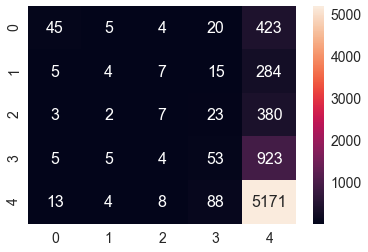

In [66]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
mnb = MultinomialNB(alpha=.0001)
mnb.fit(X_traintfidf_counts,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='micro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='micro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(5),range(5))
sns.set(font_scale=1.4) #for label size                     
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [77]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,mnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-18.1434	aaaaah         				-5.9046	product        
	-18.1434	aaaaah awak    				-5.9142	tast           
	-18.1434	aaah           				-5.9817	like           
	-18.1434	aaah miss      				-5.9988	order          
	-18.1434	aagh           				-6.3365	one            
	-18.1434	aagh yelp      				-6.3509	would          
	-18.1434	aah            				-6.4950	tri            
	-18.1434	aah order      				-6.5366	box            
	-18.1434	aardvark       				-6.5552	buy            
	-18.1434	aardvark although				-6.6524	receiv         
	-18.1434	ab             				-6.6583	item           
	-18.1434	ab diet        				-6.6638	ship           
	-18.1434	aback          				-6.6640	even           
	-18.1434	aback first    				-6.6937	dont           
	-18.1434	aback paid     				-6.6940	get            
	-18.1434	aback price    				-6.6961	eat            
	-18.1434	abandon        		

# Genism

Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, 
SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections,
using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software 
packages that only target batch and in-memory processing.

In [1]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

C:\Users\Shashank\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

C:\Users\Shashank\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


3000000

# Word2Vec

In [13]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [14]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [15]:
words = list(w2v_model.wv.vocab)    

print(len(words))


35140


# Average Word2vec

In [16]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

393919


In [17]:
#sample data points
new_final_sent=sent_vectors[:25001]
new_final=final[:25001]

In [18]:
#Not shuffling the data as we want it on time basis
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_final_sent,new_final['Score'].values,test_size=0.3,shuffle=False)

In [19]:
X_train=np.isnan(X_train)
np.where(np.isnan(X_train))
np.nan_to_num(X_train)
X_test=np.isnan(X_test)
np.where(np.isnan(X_test))
np.nan_to_num(X_test)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)

In [21]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import TimeSeriesSplit

bnb = BernoulliNB()
param_grid = {'alpha':[10000,7500,5000,2500,1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.9s finished


Best HyperParameter:  {'alpha': 10000}
Best Accuracy: 69.93%


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


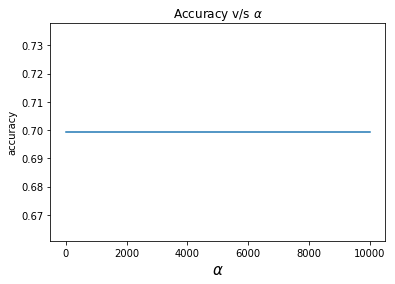

In [22]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 70.444%
Precision on test set: 0.704
Recall on test set: 0.704
F1-Score on test set: 0.704
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



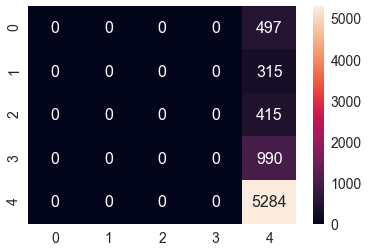

In [26]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
bnb =  BernoulliNB(alpha=10000)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='micro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='micro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(5),range(5))
sns.set(font_scale=1.4) #for label size                     
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Tf-idf W2Vec

Another way to covert sentence into vectors
Take weighted sum of the vectors divided by the sum of all the tfidf's 
i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [30]:
new_tfidf_sent_vectors=tfidf_sent_vectors[:25001]
new_final=final[:25001]

In [31]:
#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(new_tfidf_sent_vectors,new_final['Score'].values,test_size=0.3,shuffle=False)

In [32]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)

In [33]:
X_train=np.isnan(X_train)
np.where(np.isnan(X_train))
np.nan_to_num(X_train)
X_test=np.isnan(X_test)
np.where(np.isnan(X_test))
np.nan_to_num(X_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [35]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import TimeSeriesSplit

bnb = BernoulliNB()
param_grid = {'alpha':[100000,75000,50000,25000,10000,7500,5000,2500,1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))


Wall time: 0 ns
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'alpha': 100000}
Best Accuracy: 69.93%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.4s finished


C:\Users\Shashank\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


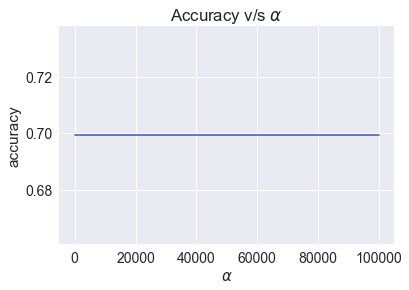

In [36]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 70.444%
Precision on test set: 0.704
Recall on test set: 0.704
F1-Score on test set: 0.704
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



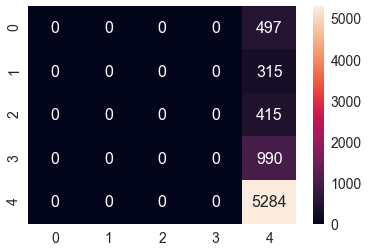

In [40]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
bnb = BernoulliNB(alpha=100000)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='micro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='micro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='micro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(5),range(5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


# Conclusions

1.The best thing about Naive Bayes it much quicker than algorithms amazingly fast training times

2.Best Models with accuracy of 89.53% and precision of 0.594

3.Multinomial Naive Bayes does not work with negative values

4.Naive Bayes fails miserably with featurization of Word2Vec and tfidf Word2Vec as Word2Vec feature are completely 
  dependent while Naive Bayes is based on assumption of feature independence